In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# 评价指标
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


In [12]:
train = pd.read_csv(r'C:\Users\ALIENWARE\Desktop\DATA\train.csv')
test = pd.read_csv(r'C:\Users\ALIENWARE\Desktop\DATA\testA.csv')

In [23]:
print(f"训练集: {train.shape[0]}条记录, {train.shape[1]}个特征")
print(f"测试集: {test.shape[0]}条记录, {test.shape[1]}个特征")

训练集: 800000条记录, 47个特征
测试集: 200000条记录, 46个特征


In [ ]:
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [14]:
#  样本个数和特征维度
train.shape
# (800000, 47)
test.shape
# (200000, 46)


(200000, 46)

In [ ]:
train.columns


"\nIndex(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',\n       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',\n       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',\n       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',\n       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',\n       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',\n       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',\n       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',\n       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],\n      dtype='object')\n"

In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

"\n<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 800000 entries, 0 to 799999\nData columns (total 47 columns):\nid                    800000 non-null int64\nloanAmnt              800000 non-null float64\nterm                  800000 non-null int64\ninterestRate          800000 non-null float64\ninstallment           800000 non-null float64\ngrade                 800000 non-null object\nsubGrade              800000 non-null object\nemploymentTitle       799999 non-null float64\nemploymentLength      753201 non-null object\nhomeOwnership         800000 non-null int64\nannualIncome          800000 non-null float64\nverificationStatus    800000 non-null int64\nissueDate             800000 non-null object\nisDefault             800000 non-null int64\npurpose               800000 non-null int64\npostCode              799999 non-null float64\nregionCode            800000 non-null int64\ndti                   799761 non-null float64\ndelinquency_2years    800000 non-null float64\nficoRang

In [17]:
train.describe()
# train.describe().T

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,isDefault,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,...,759730.000000,759730.000000,759730.000000,759729.000000,759730.000000,766761.000000,730248.000000,759730.000000,759730.000000,759730.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,72005.351714,0.614213,7.613391e+04,1.009683,0.199513,...,8.107937,8.575994,8.282953,14.622488,5.592345,11.643896,0.000815,0.003384,0.089366,2.178606
std,230940.252015,8716.086178,0.855832,4.765757,261.460393,106585.640204,0.675749,6.894751e+04,0.782716,0.399634,...,4.799210,7.400536,4.561689,8.124610,3.216184,5.484104,0.030075,0.062041,0.509069,1.844377
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,427.000000,0.000000,4.560000e+04,0.000000,0.000000,...,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,7755.000000,1.000000,6.500000e+04,1.000000,0.000000,...,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,117663.500000,1.000000,9.000000e+04,2.000000,0.000000,...,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000
max,799999.000000,40000.000000,5.000000,30.990000,1715.420000,378351.000000,5.000000,1.099920e+07,2.000000,1.000000,...,70.000000,132.000000,79.000000,128.000000,45.000000,82.000000,4.000000,4.000000,39.000000,30.000000


In [18]:
# 数值类型
numerical_feature = list(train.select_dtypes(exclude=['object']).columns)
numerical_feature


['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [19]:
len(numerical_feature)  ## 42


42

In [20]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for fea in numerical_feature:
    temp = train[fea].nunique()# 返回的是唯一值的个数
    if temp == 1:
        unique_feature.append(fea)
     # 自定义变量的值的取值个数小于10就为离散型变量    
    elif temp <= 10:
        discrete_feature.append(fea)
    else:
        serial_feature.append(fea)


In [21]:
serial_feature

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

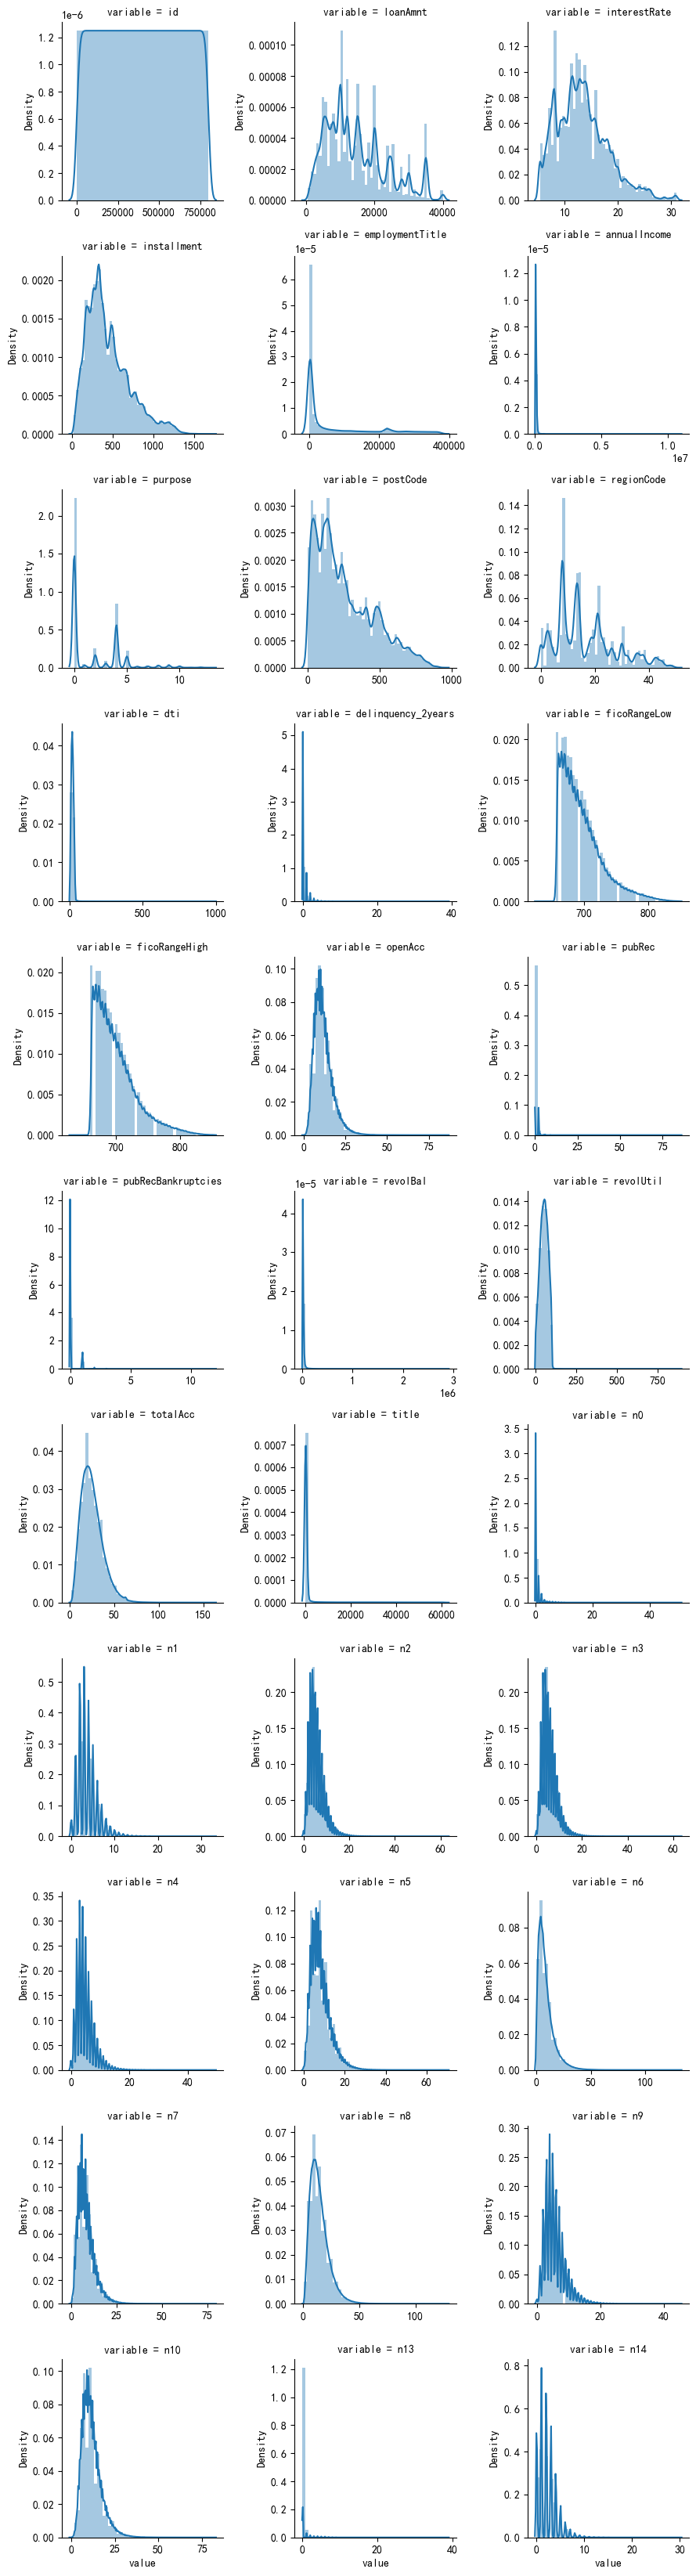

In [22]:
#每个数字特征得分布可视化
f = pd.melt(train, value_vars=serial_feature)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


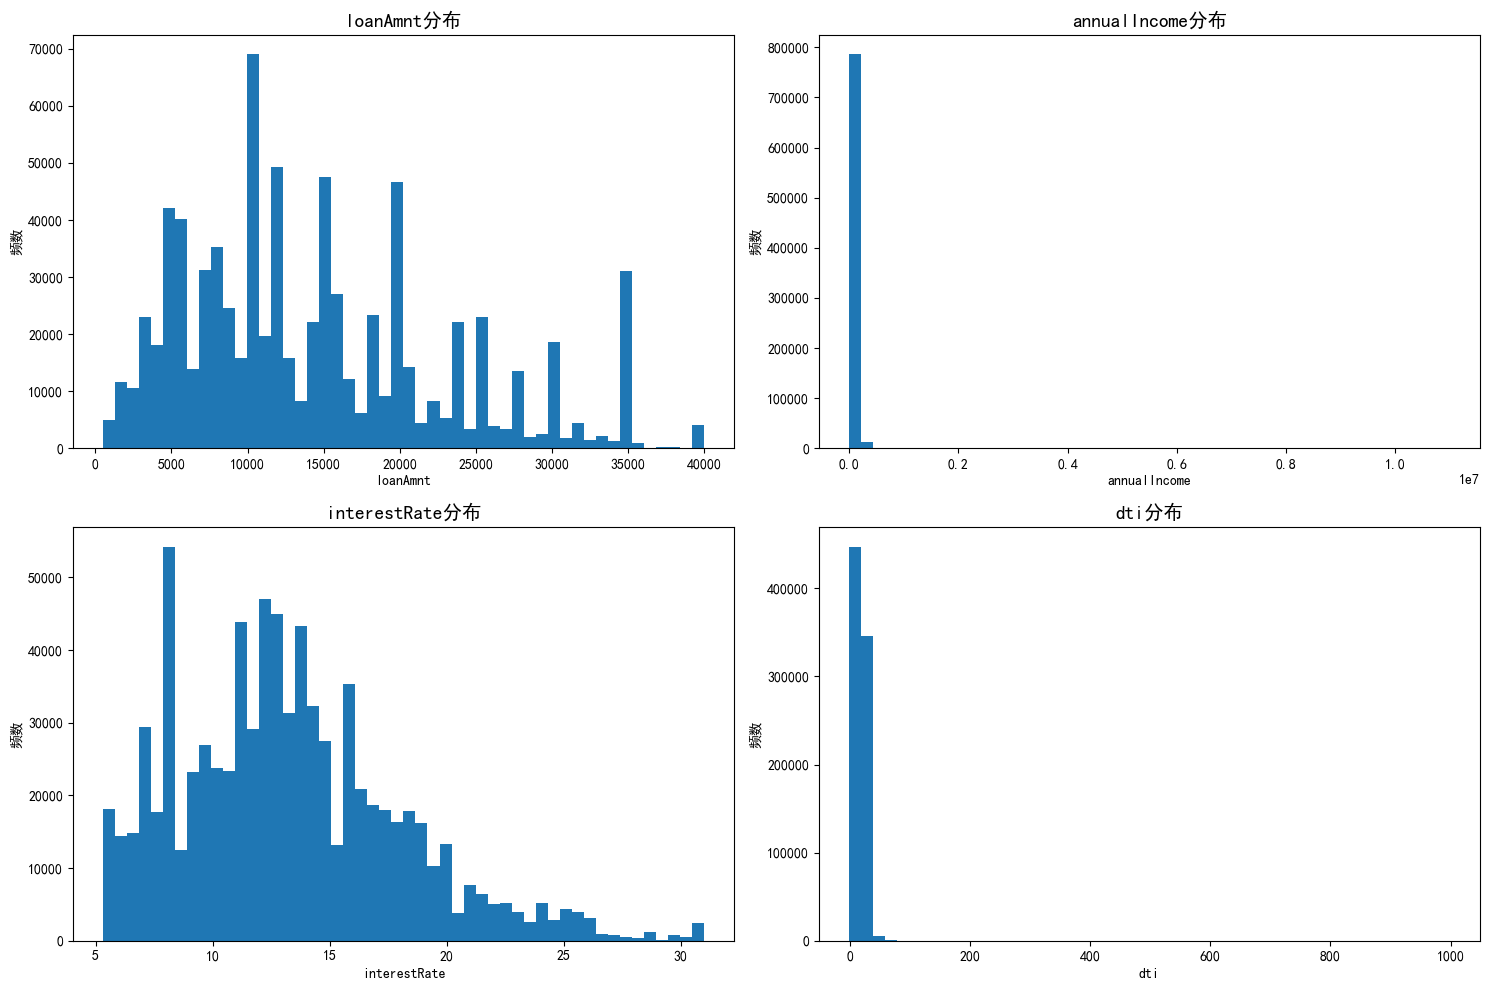

In [25]:
# 数值特征分布可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
num_features = ['loanAmnt', 'annualIncome', 'interestRate', 'dti']

for i, feat in enumerate(num_features):
    ax = axes[i//2, i%2]
    ax.hist(train[feat], bins=50)
    ax.set_title(f'{feat}分布', fontsize=14)
    ax.set_xlabel(feat)
    ax.set_ylabel('频数')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'loanAmnt')

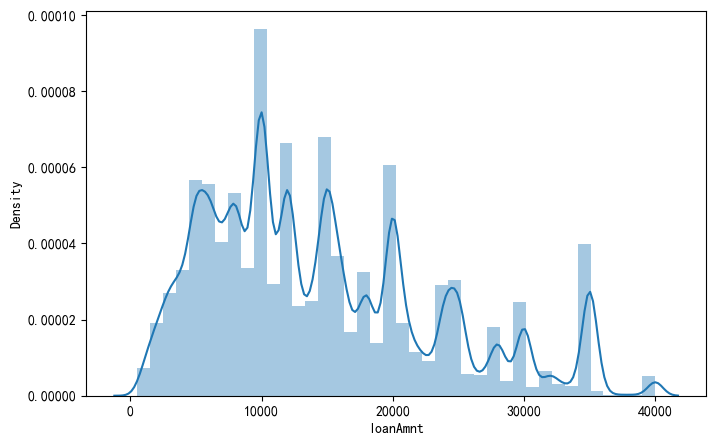

In [26]:
plt.figure(1 , figsize = (8 , 5))
sns.distplot(train.loanAmnt,bins=40)
plt.xlabel('loanAmnt')


In [29]:
discrete_feature

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [30]:
for f in discrete_feature:
    print(f, '类型数：', train[f].nunique())


term 类型数： 2
homeOwnership 类型数： 6
verificationStatus 类型数： 3
isDefault 类型数： 2
initialListStatus 类型数： 2
applicationType 类型数： 2
n11 类型数： 5
n12 类型数： 5


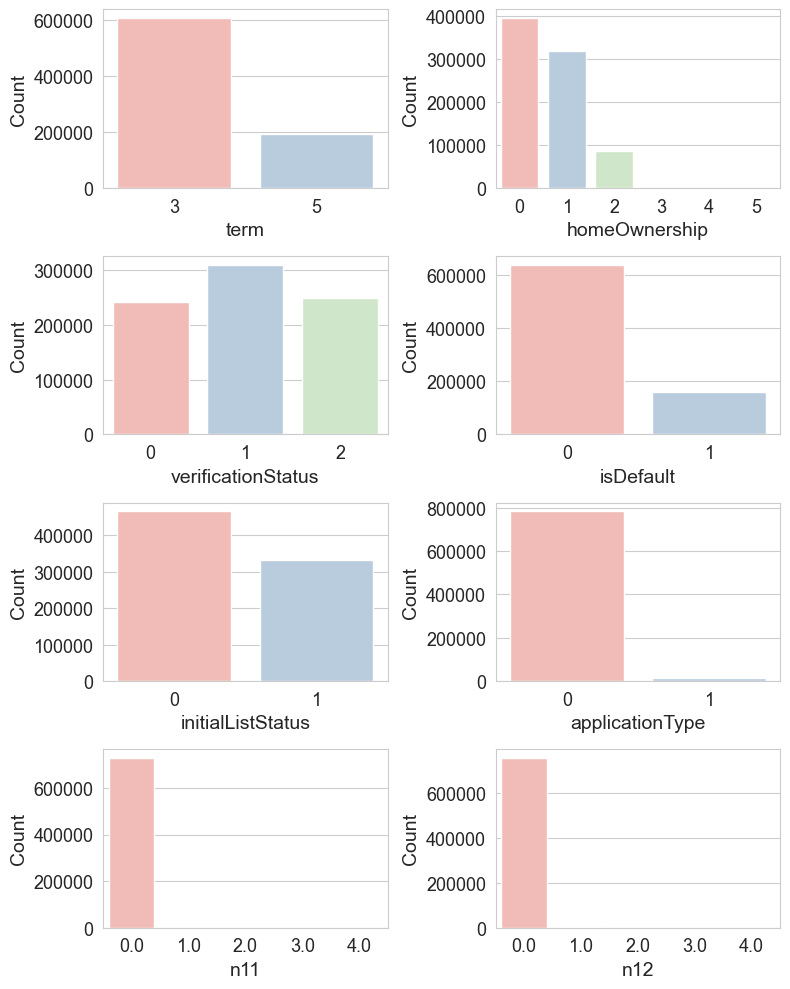

In [32]:
df_ = train[discrete_feature]

sns.set_style("whitegrid") # 使用whitegrid主题
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(8,10))
for i, item in enumerate(df_):
    plt.subplot(4,2,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(x = item,data = df_,palette="Pastel1")
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()

In [33]:
unique_feature

['policyCode']

In [34]:
# 分类型特征
category_feature = list(filter(lambda x: x not in numerical_feature,list(train.columns)))
category_feature

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [35]:
train[category_feature]

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002
799998,A,A4,10+ years,2015-02-01,Jan-1994


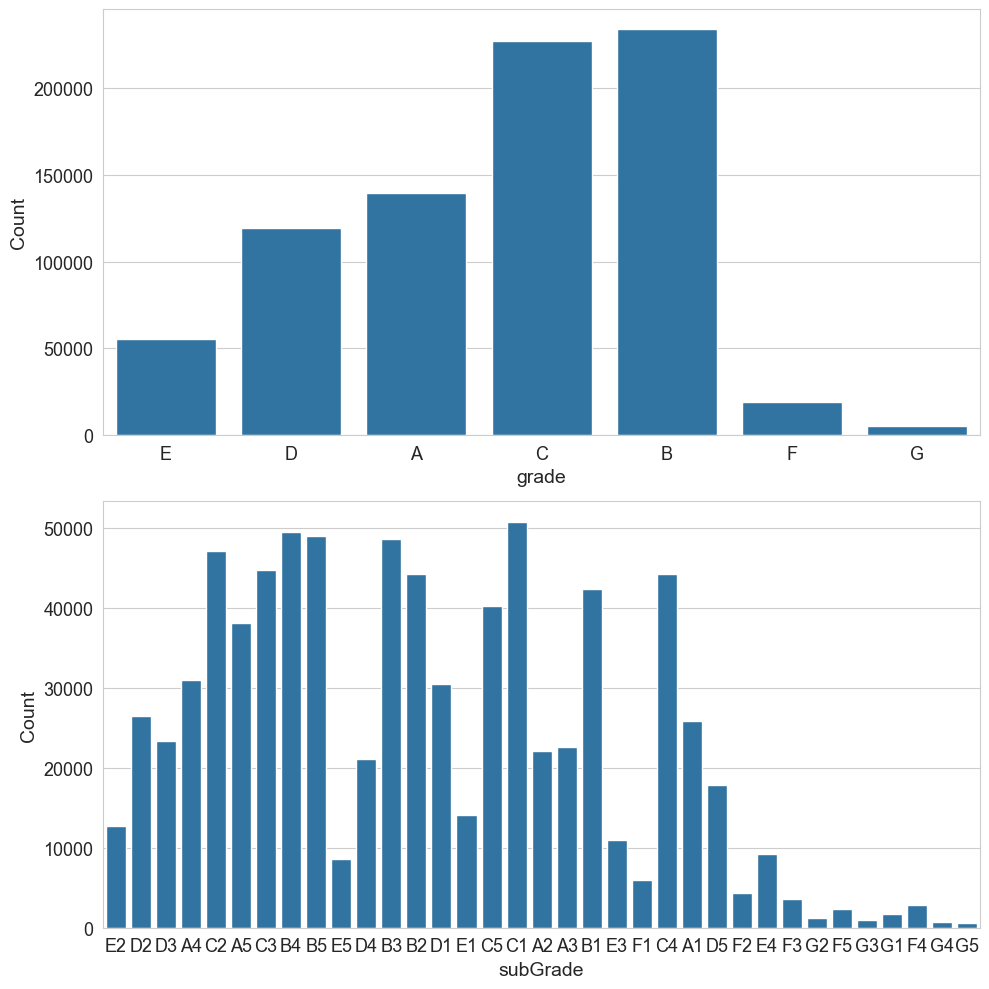

In [37]:
df_category = train[['grade', 'subGrade']]

sns.set_style("whitegrid") # 使用whitegrid主题
color = sns.color_palette()
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
for i, item in enumerate(df_category):
    plt.subplot(2,1,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(x = item,data = df_category)
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()


In [ ]:
label=train.isDefault             
label.value_counts()/len(label)
sns.countplot(label)